# Achintya Krishnan -- Astro 503 Midterm

In [1]:
# I'm not telling you what to import this time - it's an exam! 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson as simp
import pandas as pd
from scipy.fft import fft, fftfreq
import scipy.signal.windows as window
from scipy.optimize import curve_fit
from scipy import signal
from astropy.io import fits
from astropy import stats as apstats
from astropy.wcs import WCS
from trilogy import trilogy
from PIL import Image as PIL_Img
from datetime import datetime, date

# suppress warning messages -- just makes output cleaner
import warnings
warnings.filterwarnings("ignore")

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

### Part a

In [3]:
# signals (2 in total)
np.random.seed(54)                    # set seed

tvals = np.linspace(0,1, num=10**3)   # 0 --> 1 second
clean_signal = np.sin(5.5*2*np.pi*tvals)   # sine wave with frequency = 5.5 Hz (clean)

base_of_dirty_signal = np.sin(60*2*np.pi*tvals)   # continuum = sine wave with frequency = 60 Hz
Gaussian_correction = np.random.normal(loc=0, scale=0.25,size=len(base_of_dirty_signal))  # Gaussian with mean=0 and std=0.25
dirty_signal = base_of_dirty_signal + Gaussian_correction   # dirty signal = continuum + Gaussian correction

In [4]:
# noises (3 in total)
np.random.seed(907)   # set seed

# white noise (1/f^0) = Gaussian
white_noise = np.random.normal(loc=0, scale=1, size=len(tvals))    

# obtain brownian noise (1/f^2) by integrating white noise
    # brownian noise at t1 = integral of white noise timestream from 0->t1
brown_noise = np.zeros_like(tvals)
for i in range(0, len(tvals)):
    brown_noise[i] = simp(y=white_noise[0:i+1], x=tvals[0:i+1])

# Obtain pink (1/f) noise via finite difference eqn:
    # xt = (x_t-1 + x_t-1^2) mod 1
pink_noise = np.zeros_like(tvals)  # array to house pink noise values
pink_noise[0] = np.random.uniform(0,1) 
    # set first number = random # between 0 & 1 (can't choose 0 or else all other numbers will be 0)
for j in range(1, len(tvals)):
    pink_noise[j] = np.mod(pink_noise[j-1] + pink_noise[j-1]**2, 1.)

In [5]:
# total (all signals + noises)
tot_sig_plus_noise = clean_signal + dirty_signal + white_noise + brown_noise + pink_noise

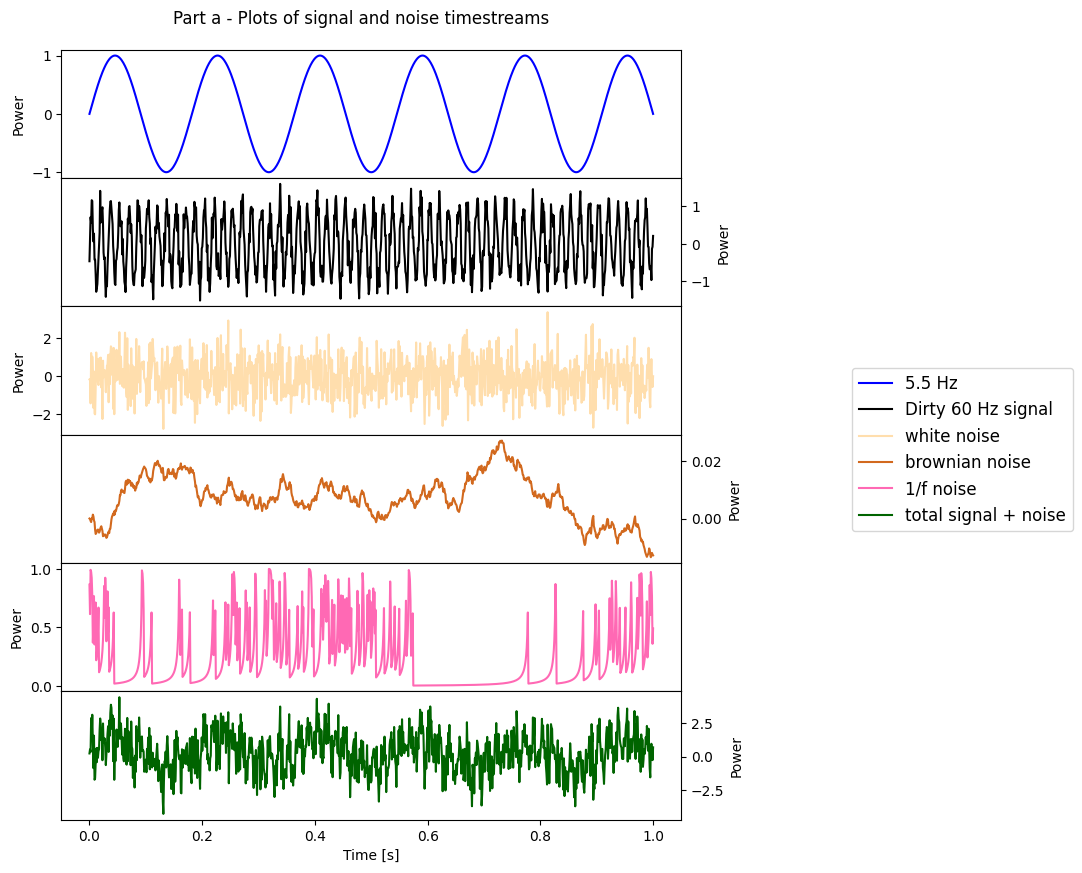

In [6]:
fig,ax = plt.subplots(6, figsize=(8, 10))
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Part a - Plots of signal and noise timestreams', y=0.92)

# 5.5 Hz (clean) signal
ax[0].plot(tvals, clean_signal, label='5.5 Hz', color='blue')
ax[0].set_ylabel('Power')

# Dirty 60 Hz signal
ax[1].plot(tvals, dirty_signal, label='Dirty 60 Hz signal', color='black')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylabel('Power')

# white noise 
ax[2].plot(tvals, white_noise, label='white noise', color='navajowhite')
ax[2].set_ylabel('Power')

# brownian noise
ax[3].plot(tvals, brown_noise, label='brownian noise', color='chocolate')
ax[3].yaxis.set_label_position("right")
ax[3].yaxis.tick_right()
ax[3].set_ylabel('Power')

# 1/f noise
ax[4].plot(tvals, pink_noise, label='1/f noise', color='hotpink')
ax[4].set_ylabel('Power')

# Total signal + noise
ax[5].plot(tvals, tot_sig_plus_noise, label='total signal + noise', color='darkgreen')
ax[5].set_xlabel('Time [s]')
ax[5].yaxis.set_label_position("right")
ax[5].yaxis.tick_right()
ax[5].set_ylabel('Power')

# Create single legend for entire figure
handles = []
labels = []
for counter in range(0, 6):
    handles.append(ax[counter].get_legend_handles_labels()[0][0])
    labels.append(ax[counter].get_legend_handles_labels()[1][0])
fig.legend(handles, labels, bbox_to_anchor=(1.4,0.57), fontsize=12)
plt.show()

### Part b

In [7]:
# Put all timestreams into a dictionary (all elements = np arrays)
ts_dict = {
    'time': tvals,
    'clean 5.5 Hz signal': clean_signal,
    'dirty 60 Hz signal': dirty_signal,
    'white noise': white_noise, 
    'brownian noise': brown_noise,
    '1/f noise': pink_noise,
    'total signal + noise': tot_sig_plus_noise
}

In [8]:
# empty lists to house results to be printed for part b
stdev_ls = []
numSamplesAbove_ls = []
numSamplesBelow_ls = []

# Measure stdev of each timestream and count # of samples above/below 3*stdev from median
for timestream in ts_dict:
    if timestream != 'time':
        stdev = np.std(ts_dict[timestream])
        med_val = np.median(ts_dict[timestream])
        p3sig = med_val + 3*stdev   #+3 sigma value
        m3sig = med_val - 3*stdev   #-3 sigma value
        numSamplesAbove = len(np.where(ts_dict[timestream] > p3sig)[0]) # num samples 3 sigma above median
        numSamplesBelow = len(np.where(ts_dict[timestream] < m3sig)[0]) # num samples 3 sigma below median
    
        # house results in empty lists created above
        stdev_ls.append(stdev)
        numSamplesAbove_ls.append(numSamplesAbove)
        numSamplesBelow_ls.append(numSamplesBelow)
        
# Dictionary with results to be printed/shown for part b
ptb_results = pd.DataFrame({"timestream": list(ts_dict.keys())[1::],     # exclude tvals key in ts_dict
                            "standard deviation": stdev_ls, 
                            "# of samples 3 sigma above median": numSamplesAbove_ls, 
                           "# of samples 3 sigma below median": numSamplesBelow_ls})
ptb_results["total # of samples 3 sigma outside median"] = ptb_results["# of samples 3 sigma above median"] + ptb_results["# of samples 3 sigma below median"]
    # calculate total # of samples outside 3 sigma in either direction
ptb_results = ptb_results.set_index("timestream")
    # reset index to be the timestream

# display results
print('Note that there are '+str(len(ts_dict["time"]))+' samples in each timestream.')
ptb_results

Note that there are 1000 samples in each timestream.


,standard deviation,# of samples 3 sigma above median,# of samples 3 sigma below median,total # of samples 3 sigma outside median
timestream,,,,
clean 5.5 Hz signal,0.704385,0,0,0
dirty 60 Hz signal,0.732675,0,0,0
white noise,0.995831,1,0,1
brownian noise,0.007684,0,0,0
1/f noise,0.268297,24,0,24
total signal + noise,1.432125,0,1,1


### Part c

In [9]:
# Create new (empty) dictionary to house PSDs of timestreams
ts_dict_keys = list(ts_dict.keys())
PSD_dict = dict({})
for keyname in ts_dict_keys:
    if keyname == 'time':
        PSD_dict["freq"] = []
    else:
        PSD_dict[keyname] = []

In [10]:
# Number of sample points
N = len(ts_dict["time"])   # tvals = linspace so spacing between all successive elements = the same
Delta_t = ts_dict["time"][1] - ts_dict["time"][0]  # sample spacing

# get window function
wind = window.bartlett(N)

# Calculate fourier transformed timestreams via Scipy fft
for ts in ts_dict:
    if ts == 'time':
        PSD_dict['freq'] = fftfreq(N, Delta_t)[1:int(N/2)]   # only want positive frequencies
        # recall that (d_n)* = d_-n and P_n = |d_n|^2 (so PSD is symmetric about negative and positive frequencies)
            # i.e. P_n = P_-n
    else:
        fourier_of_ts =  fft(ts_dict[ts]*wind)[1:int(N/2)]   # fourier transform of timestream * window function
        PSD_dict[ts] = np.abs(fourier_of_ts)**2              # spectral power = |fourier component|^2

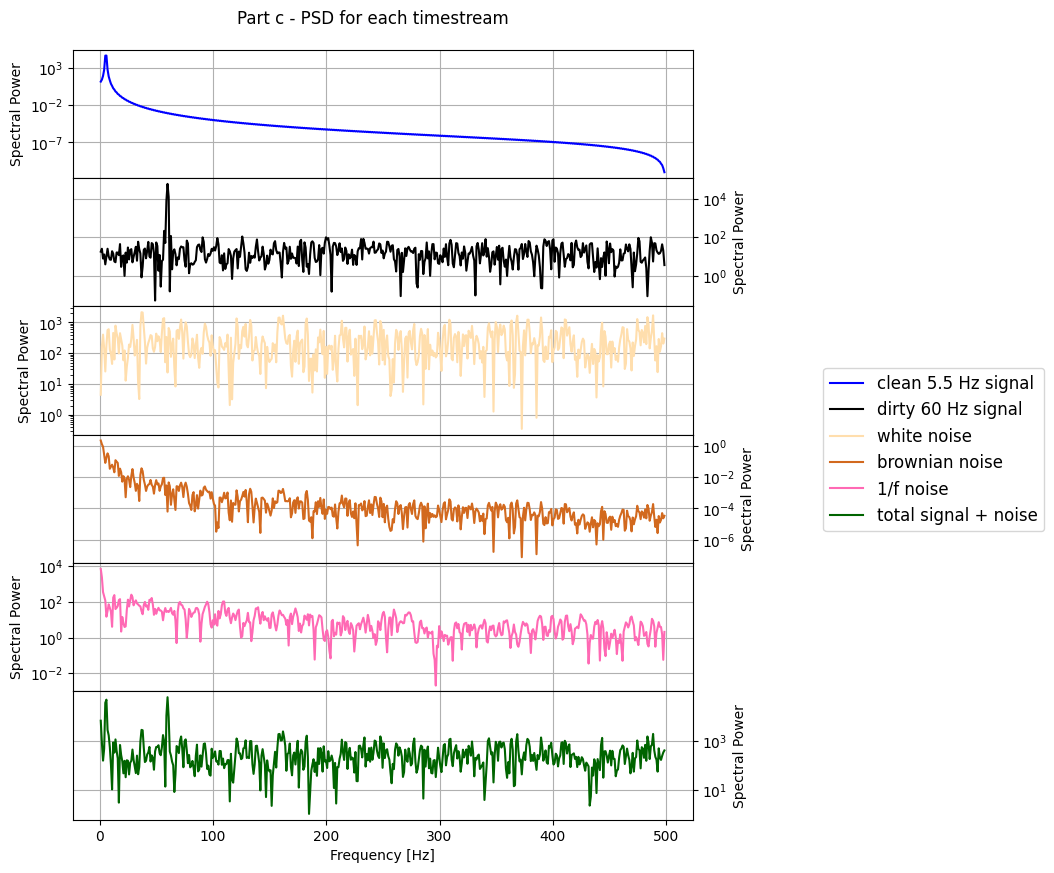

In [11]:
# Plot the PSDs for each timestream
fig2,ax2 = plt.subplots(len(PSD_dict)-1, figsize=(8, 10))
plt.subplots_adjust(hspace=0, wspace=0)
fig2.suptitle('Part c - PSD for each timestream', y=0.92)
plot_colors = ['blue','black','navajowhite','chocolate','hotpink','darkgreen']
    # same colors (in order of timestreams in PSD_dict) as used in pt a plot
PSD_dict_keys = list(PSD_dict.keys())  # list of keys in PSD_dict, will iterate over them
    
for index in range(1,len(PSD_dict)):   # index = 0 ==> frequencies
    ax2[index-1].plot(PSD_dict['freq'], PSD_dict[PSD_dict_keys[index]], color=plot_colors[index-1], 
                   label=PSD_dict_keys[index])
    ax2[index-1].set_xscale('linear')
    ax2[index-1].set_yscale('log')
    ax2[index-1].set_ylabel('Spectral Power')
    ax2[index-1].grid(True)
    
    if np.remainder(index-1, 2) == 1:
        ax2[index-1].yaxis.set_label_position("right")
        ax2[index-1].yaxis.tick_right()
        
ax2[-1].set_xlabel('Frequency [Hz]')

# Create single legend for entire figure
handles = []
labels = []
for counter in range(0, len(PSD_dict)-1):
    handles.append(ax2[counter].get_legend_handles_labels()[0][0])
    labels.append(ax2[counter].get_legend_handles_labels()[1][0])
fig2.legend(handles, labels, bbox_to_anchor=(1.35,0.57), fontsize=12);

### Part d

The goal here is to fit a power law $P = Af^{-\alpha}$, where A is some normalization constant, to each of the noise PSDs. 

For brownian and pink noise PSDs, the continuum's maximum is multiple orders of magnitude larger than the continuum's minimum. Therefore, fitting the above power law to the PSD directly (i.e. fitting to the spectral power vs. frequency data) will basically only fit to the PSD in the neighborhood of its maximum. Thus, there will be massive degeneracy near the continuum minimum. 

To remedy this, it is better to fit a line to the logscaled (along both axes) PSD (i.e. log spectral power vs. log frequency data). The line's functional form comes from simply taking the natural log of both sides of the power law to get:

\begin{equation}\boxed{
\ln(P) = \ln(A) -\alpha \ln(f)}
\end{equation}

This will sacrifice goodness of fit near the continuum maximum to a certain extent, but will dramatically increase goodness of fit near the continuum minimum --- making for a better overall fit.

Also, note that in this case, the covariance matrix outputted by scipy's curve_fit function will have the form:

$$C = \begin{pmatrix}
\mathrm{Var}(\alpha) &  \\
 & \mathrm{Var}[\ln(A)]
\end{pmatrix}$$

Therefore, the error for $\alpha$ will be:

\begin{equation}\boxed{
\sigma_\alpha = \sqrt{C_{00}} = \sqrt{\mathrm{Var}[\alpha]}}
\end{equation}

For the error of $A$, we will need to do find a little math. Consider an arbitrary function $f$ of a random variable $X$. The variance of $f(X)$ is:

$$\mathrm{Var}[f(X)] = E\left( f^2(X) \right) - E^2(f(X))$$

Taylor expand (to 2nd order) the arguments of both expectation terms on the RHS about $E(X) = \mu$ = mean of $X$:

$$\mathrm{Var}[f(X)] \approx E\left[f^2(\mu) + (X-\mu)\frac{d}{dx}(f^2)|_\mu + \frac{(X-\mu)^2}{2}\frac{d^2}{dX^2}(f^2)|_\mu    \right] - E^2\left[f(\mu) + (X-\mu)\frac{d}{dx}f|_\mu + \frac{(X-\mu)^2}{2}\frac{d^2}{dX^2}f|_\mu    \right]$$

Letting primes denote derivatives wrt $X$ and using the linearity of the expectation operator: 

$$\mathrm{Var}[f(X)] \approx f^2(\mu) + 2f(\mu)f'(\mu)E[X-\mu] + \left(f(\mu)f''(\mu) + (f'(\mu))^2\right)E[(X-\mu)^2] - \left(f(\mu) + f'(\mu)E[X-\mu] + \frac{f''(\mu)}{2}E[(X-\mu)^2]\right)^2$$

Recall that $\mathrm{Var}[X] = E\left[ (X-\mu)^2 \right]$ by definition. Also, $E[X-\mu] = E[X] - E[\mu] = E[X] - \mu = E[X] - E[X] = 0$. This allows us to rewrite the above equation as:

$$\mathrm{Var}[f(X)] \approx f^2(\mu) + \left(f(\mu)f''(\mu) + (f'(\mu))^2\right)\mathrm{Var}[X] - \left(f(\mu) + \frac{f''(\mu)}{2}\mathrm{Var}[X]\right)^2$$

$$\mathrm{Var}[f(X)] \approx f^2(\mu) + \left(f(\mu)f''(\mu) + (f'(\mu))^2\right)\mathrm{Var}[X] - \left(f^2(\mu) + \frac{(f''(\mu))^2}{4}\mathrm{Var}^2[X]  + f(\mu)f''(\mu)\mathrm{Var}[X]   \right)$$

$$\mathrm{Var}[f(X)] \approx  (f'(\mu))^2\mathrm{Var}[X] - \left(\frac{(f''(\mu))^2}{4}\mathrm{Var}^2[X]   \right)$$

In our case $X \rightarrow A$, and $f(A) = \ln(A)$. We take $\mu \rightarrow \mu_A = E[A]$ = best-fit value of A = $e^{\text{best-fit value of ln(A)}}$. Therefore, we have that $f'(A) = 1/A$ and $f''(A) = -1/A^2$. Plugging this into the equation above gives:

$$\mathrm{Var}[\ln(A)] \approx  \frac{1}{\mu_A^2}\mathrm{Var}[A] - \frac{1}{4\mu_A^4}\mathrm{Var}^2[A]$$

$$4\mu_A^4 \mathrm{Var}[\ln(A)] \approx 4\mu_A^2\mathrm{Var}[A] - \mathrm{Var}^2[A]$$

$$\mathrm{Var}^2[A] - 4\mu_A^2\mathrm{Var}[A] + 4\mu_A^4 \mathrm{Var}[\ln(A)] \approx 0$$

This can be solved with the quadratic equation for $\mathrm{Var}[A]$ as:

$$\mathrm{Var}[A] \approx \frac{4\mu_A^2 \pm \sqrt{16\mu_A^4 - 16\mu_A^4\mathrm{Var}[\ln(A)]}}{2} = 2\mu_A^2\left(1 \pm \sqrt{1-\mathrm{Var}[\ln(A)]}\right)$$

We take the negative solution. Error is just the standard deviation, which is just the square root of the variance, so:

\begin{equation}\boxed{
\sigma_A = \sqrt{\mathrm{Var}[A]} \approx  \sqrt{2\mu_A^2\left(1 - \sqrt{1-\mathrm{Var}[\ln(A)]}\right)} = \sqrt{2\mu_A^2\left(1 - \sqrt{1- C_{11}}\right)}}
\end{equation}

**Note: $C_{ii}$ is the ith term along the diagonal of the covariance matrix $C$.

In [12]:
def noise_logscaled_power_law(lnfreq, alpha, lnA):
    # noise has PSD with power law of form A/f^alpha
        # equivalent to ln(P) = ln(A) - alpha*ln(f)
        # note: prefix ln ===> natural log
    # freq = frequency
    # alpha = scalar
    # A = normalization factor
    
    # outputs ln(P) = natural log(spectral power)
    
    return lnA - alpha * lnfreq

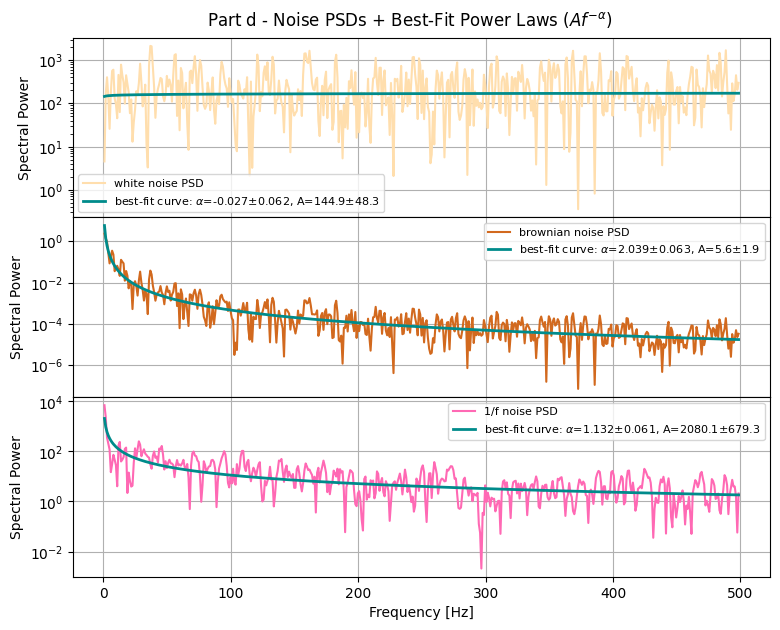

In [13]:
# Do curve fitting and plot the noise PSDs along with best fits

noisePSD_keys = list(PSD_dict.keys())[3:6]   # extract the noise entries in the PSD dict

fig3,ax3 = plt.subplots(len(noisePSD_keys), figsize=(9, 7))
plt.subplots_adjust(hspace=0, wspace=0)
fig3.suptitle(r'Part d - Noise PSDs + Best-Fit Power Laws ($Af^{-\alpha}$)', y=0.92)
plot_colors = ['navajowhite','chocolate','hotpink']
    # same colors used for noises in parts a & c plots

    
for ind in range(0, len(noisePSD_keys)):
    ax3[ind].plot(PSD_dict['freq'], PSD_dict[noisePSD_keys[ind]], color=plot_colors[ind],   # plot noise PSD
                   label=noisePSD_keys[ind]+' PSD')
    
    ##########
    #Do curve fitting and plot best-fit power law
        # see markdown cell at top of part d for math/logic used in this curve-fitting process
    if noisePSD_keys[ind] == 'white noise':
        initGuess = [0,1]
    elif noisePSD_keys[ind] == 'brownian noise':
        initGuess = [2,1]
    elif noisePSD_keys[ind] == '1/f noise':
        initGuess = [1,1]
        
    logpopt,logpcov = curve_fit(f=noise_logscaled_power_law,                    
                          xdata=np.log(PSD_dict["freq"]), 
                          ydata=np.log(PSD_dict[noisePSD_keys[ind]]), 
                          p0=initGuess) 
        # do curve fitting to log(power) vs log(freq) using 'logscaled' power law
        # logpopt contains alpha, lnA
        # logpcov's diag elements ==> (variance of alpha, variance of lnA)
    
    # convert to best-fit alpha, A  and their errors
    best_fit_alpha = logpopt[0]
    alpha_error = np.sqrt(logpcov[0][0])
    best_fit_A = np.exp(logpopt[1])
    A_error = np.sqrt(2*best_fit_A**2 * (1 - np.sqrt(1-logpcov[1][1])))   # see markdown cell above
    
    # calculate best_fit spectral power vs freq curve given fitted alpha,A
    best_fit_curve = best_fit_A*PSD_dict["freq"]**(-best_fit_alpha)
    
    # plot best-fit spec power vs freq curve
    ax3[ind].plot(PSD_dict["freq"], best_fit_curve, color='darkcyan', ls='-', lw=2,
                 label=r'best-fit curve: $\alpha$='+str(round(best_fit_alpha,3))+'$\pm$'+str(round(alpha_error,3))+', A='+str(round(best_fit_A,1))+'$\pm$'+str(round(A_error,1))
                 )
 
    ax3[ind].legend(fontsize=8)
    ##########
    
    ax3[ind].set_xscale('linear')
    ax3[ind].set_yscale('log')
    ax3[ind].set_ylabel('Spectral Power')
    ax3[ind].grid(True)
    
ax3[-1].set_xlabel('Frequency [Hz]');

### Part e

In [14]:
cutoff_freq = 150   # cutoff frequency (in Hz) for both high-pass and low-pass filters
    # I'm choosing to use the same cutoff for both filters
butter_order = 25
    # order of butterworth filter
    # must be integer >= 1
    
butter_lp_filt = signal.butter(N=butter_order, Wn=cutoff_freq, btype='lowpass', analog=False, 
                               fs=len(ts_dict["time"])/(ts_dict["time"].max() - ts_dict["time"].min()), 
                               output='sos')   
    #butterworth low-pass digital filter (order 10)
    #Wn in same units as fs (sampling frequency)
        # fs = number of data points in timestream / timespan of timestream

    
butter_hp_filt = signal.butter(N=butter_order, Wn=cutoff_freq, btype='highpass', analog=False, 
                               fs=len(ts_dict["time"])/(ts_dict["time"].max() - ts_dict["time"].min()),
                               output='sos')   
    #butterworth high-pass digital filter (order 10)
    #Wn in same units as fs (sampling frequency)
        # fs = number of data points in timestream / timespan of timestream

In [15]:
lp_sig_p_noise = signal.sosfilt(butter_lp_filt, ts_dict["total signal + noise"])  # low-passed timestream
hp_sig_p_noise = signal.sosfilt(butter_hp_filt, ts_dict["total signal + noise"])  # high-passed timestream

In [16]:
numPoints = len(ts_dict["time"])   # number of values in timestream
tSpacing = ts_dict["time"][1] - ts_dict["time"][0]   # equal spacing between all values of timestream

# get window function
wind2 = window.bartlett(N)

freqs = fftfreq(N, tSpacing)[1:int(numPoints/2)]   # only want positive frequencies
    # recall that (d_n)* = d_-n and P_n = |d_n|^2 (so PSD is symmetric about negative and positive frequencies)
            # i.e. P_n = P_-n

# Fourier transform and get PSD of low-passed total timestream
fourier_lp =  fft(lp_sig_p_noise*wind2)[1:int(numPoints/2)]   # fourier transform of window*timestream
PSD_tot_lp = np.abs(fourier_lp)**2

# Fourier transform and get PSD of high-passed total timestream
fourier_hp =  fft(hp_sig_p_noise*wind2)[1:int(numPoints/2)]   # fourier transform of window*timestream
PSD_tot_hp = np.abs(fourier_hp)**2

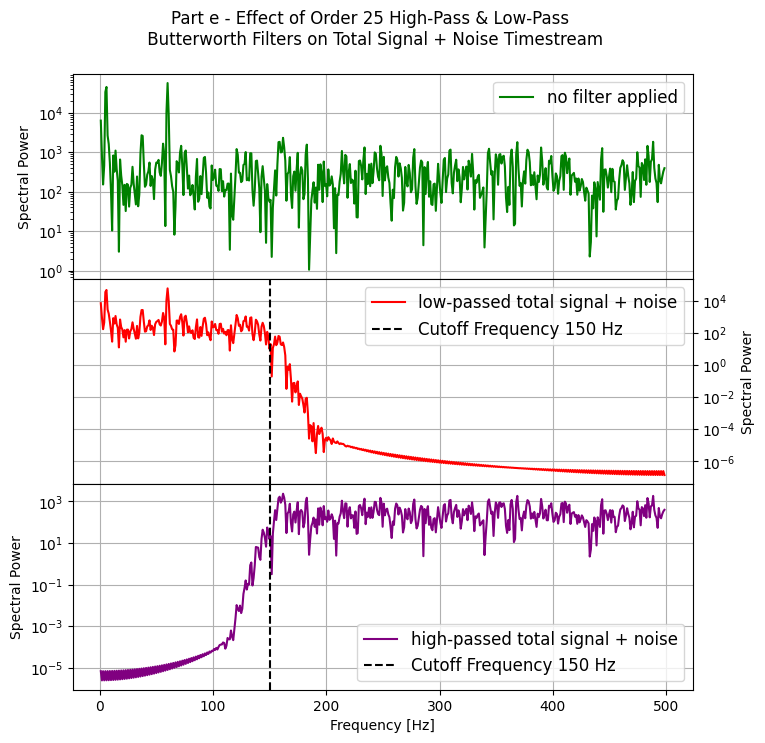

In [17]:
## Plot original, high-passed, and low-passed PSDs for total timestream
fig4,ax4 = plt.subplots(3, figsize=(8,8))
plt.subplots_adjust(hspace=0, wspace=0)
fig4.suptitle(r'Part e - Effect of Order '+str(butter_order)+' High-Pass & Low-Pass \n Butterworth Filters on Total Signal + Noise Timestream', 
              y=0.96)

# total signal + noise PSD WITH NO FILTER APPLIED
ax4[0].plot(PSD_dict['freq'], PSD_dict["total signal + noise"], color='green', label='no filter applied')
#ax4[0].axvline(cutoff_freq, color='black', linestyle='--', label='Cutoff Frequency '+str(cutoff_freq)+' Hz')
ax4[0].set_xscale('linear')
ax4[0].set_yscale('log')
ax4[0].set_ylabel('Spectral Power')
ax4[0].grid(True)
ax4[0].legend(fontsize=12)

# low-passed PSD
ax4[1].plot(freqs, PSD_tot_lp, label='low-passed total signal + noise', color='red')
ax4[1].axvline(cutoff_freq, color='black', linestyle='--', label='Cutoff Frequency '+str(cutoff_freq)+' Hz')
ax4[1].set_xscale('linear')
ax4[1].set_yscale('log')
ax4[1].yaxis.set_label_position("right")
ax4[1].yaxis.tick_right()
ax4[1].set_ylabel('Spectral Power')
ax4[1].grid(True)
ax4[1].legend(fontsize=12)

# high-passed PSD
ax4[2].plot(freqs, PSD_tot_hp, label='high-passed total signal + noise', color='purple')
ax4[2].axvline(cutoff_freq, color='black', linestyle='--', label='Cutoff Frequency '+str(cutoff_freq)+' Hz')
ax4[2].set_xscale('linear')
ax4[2].set_yscale('log')
ax4[2].set_ylabel('Spectral Power')
ax4[2].grid(True)
ax4[2].legend(fontsize=12)

ax4[-1].set_xlabel('Frequency [Hz]');

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [18]:
# fits files
filenames = {"DESg": "DESJ053816.9-503050.8_g.fits",
             "DESr": "DESJ053816.9-503050.8_r.fits",
             "DESi": "DESJ053816.9-503050.8_i.fits",
             "SPT220": "SPT0538-50_SPT_220GHz.fits",
             "ALMA870": "SPT0538-50_ALMA_870um.fits"}

# extract just the image data from the fits files
imgdata = {}
for file in filenames:
    hdu_list = fits.open(filenames[file])
    
    if file == 'ALMA870':
        imgdata[file] = hdu_list[0].data[0][0]
    else:
        imgdata[file] = hdu_list[0].data

# Calculate standard deviation of SPT and ALMA Maps
STP220_mean, SPT220_median, SPT220_stdev = apstats.sigma_clipped_stats(imgdata["SPT220"], sigma=3.0)
ALMA870_mean, ALMA870_median, ALMA870_stdev = apstats.sigma_clipped_stats(imgdata["ALMA870"], sigma=3.0)
print('SPT220 Standard Deviation: '+str(SPT220_stdev))
print('ALMA870 Standard Deviation: '+str(ALMA870_stdev))

SPT220 Standard Deviation: 7.642064e-05
ALMA870 Standard Deviation: 0.00045880597


In [19]:
# Calculate max SNR for each map
for band in imgdata:
    noise = apstats.sigma_clipped_stats(imgdata[band], sigma=3.0)[-1]
    max_sig = np.max(imgdata[band])
    max_SNR = max_sig / noise
    print('Max SNR in '+band+': '+str(max_SNR))

Max SNR in DESg: 7908.9214
Max SNR in DESr: 6447.8477
Max SNR in DESi: 4875.4795
Max SNR in SPT220: 8.916701
Max SNR in ALMA870: 57.334248


In [20]:
# Make a 3-color (RGB=IRG) image from DES
imagesRGB = {"R": [filenames["DESi"]], \
             "G": [filenames["DESr"]], \
             "B": [filenames["DESg"]]}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
      
trilogy.Trilogy(infile = None, samplesize = 20000, stampsize = 20000, maxstampsize = 20000, \
                deletetests = 1, deletefilters = 1, testfirst = 0, showwith = "PIL", \
                mode = 'RGB', imagesorder = 'RGB', imagesRGB = imagesRGB, noiselums = noiselums, images = None, \
                outname = 'multiple_band_image', satpercent = 0.0009, noiselum = 0.5, noisesig = 50, \
                noisesig0 = 10, correctbias = 0, colorsatfac = 1, combine = 'sum', show = False).run()

From input file None :
From input parameters:
samplesize = 20000
stampsize = 20000
maxstampsize = 20000
deletetests = 1
deletefilters = 1
testfirst = 0
showwith = PIL
mode = RGB
imagesRGB = {'R': ['DESJ053816.9-503050.8_i.fits'], 'G': ['DESJ053816.9-503050.8_r.fits'], 'B': ['DESJ053816.9-503050.8_g.fits']}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
outname = multiple_band_image
satpercent = 0.0009
noiselum = 0.5
noisesig = 50
noisesig0 = 10
correctbias = 0
colorsatfac = 1
combine = sum
show = False
invert = False
Default:
indir =  (default)
outdir =  (default)
thumbnail = None (default)
sampledx = 0 (default)
sampledy = 0 (default)
showstamps = 0 (default)
scaling = None (default)
legend = 0 (default)
noise = None (default)
saturate = None (default)
bscale = 1 (default)
bzero = 0 (default)
Loading image data.
If multiple filters per channel, adding data.
B
DESJ053816.9-503050.8_g.fits[0] (1140, 1113) g
B = g

G
DESJ053816.9-503050.8_r.fits[0] (1140, 1113) r
G = r

R
DESJ053816.9-503050

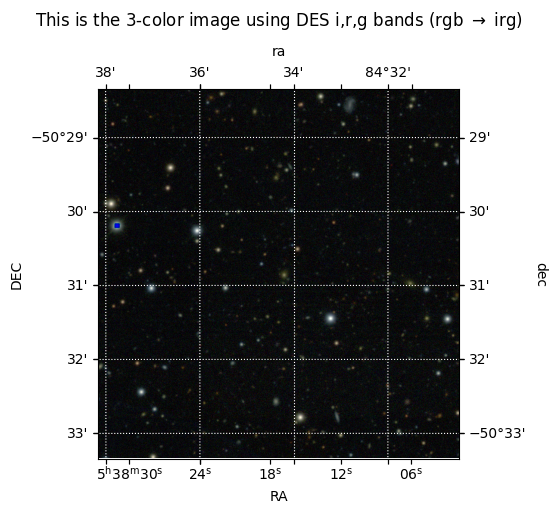

In [21]:
# read in 3-color image output by trilogy (as .png) using pillow library and convert to np array
three_color_image = PIL_Img.open('multiple_band_image.png')

# plot the 3-color-image
fig3color = plt.figure()
wcs_helix = WCS(fits.open(filenames["DESg"])[0].header)
ax3color = plt.subplot(projection=wcs_helix)
ax3color.imshow(three_color_image, origin='lower')
ax3color.set_xlabel('RA')
ax3color.set_ylabel('DEC')
plt.title(r'This is the 3-color image using DES i,r,g bands (rgb $\rightarrow$ irg)', y=1.15)

# convert axes (in pixel #s) to ICRS equatorial coordinates
overlay3color = ax3color.get_coords_overlay('icrs')
overlay3color.grid(color='white', ls='dotted')

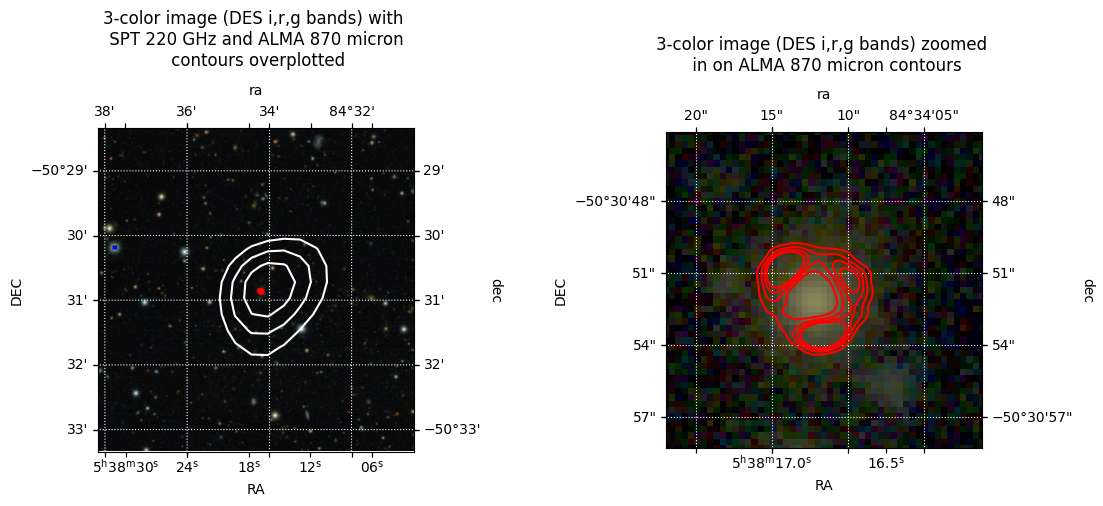

In [22]:
# will need SPT and ALMA headers for plotting
SPTheader = fits.open(filenames["SPT220"])[0].header
ALMAheader = fits.open(filenames["ALMA870"])[0].header

# Plot 3-color image with SPT and ALMA contours overlaid
fig5 = plt.figure(figsize=(np.shape(three_color_image)[0]/100, np.shape(three_color_image)[1]/100)) # figsize preserves aspect ratio
plt.subplots_adjust(wspace=0.8, hspace=0.2)   # adjust padding between subplots
wcs_helix = WCS(fits.open(filenames["DESg"])[0].header)
ax5 = plt.subplot(1,2,1,projection=wcs_helix)    # 1st (left) subplot in fig5
ax5.imshow(three_color_image, origin='lower')    # plot the 3 color image
ax5.set_title('3-color image (DES i,r,g bands) with \n SPT 220 GHz and ALMA 870 micron \n contours overplotted', y=1.17, fontsize=12)
ax5.set_xlabel('RA')
ax5.set_ylabel('DEC')
####################
# overlay SPT220 3,5,7,9 sigma contours
ax5.contour(imgdata["SPT220"], transform=ax5.get_transform(WCS(SPTheader)), levels=[3*SPT220_stdev, 5*SPT220_stdev, 7*SPT220_stdev, 9*SPT220_stdev], 
            colors='white')

# overlay ALMA870 5,10,15,20 sigma contours
ax5.contour(imgdata["ALMA870"], transform=ax5.get_transform(WCS(ALMAheader).celestial), 
            levels=[5*ALMA870_stdev, 10*ALMA870_stdev, 15*ALMA870_stdev, 20*ALMA870_stdev], colors='red')
####################
# convert axes (in pixel #s) to ICRS equatorial coordinates
overlay = ax5.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

###################################################################################################

# Add subplot for 3-color image zoomed in on ALMA contours
ax6 = plt.subplot(1,2,2,projection=wcs_helix)    # same as wcs_helix created above using DESg, 2nd (right) subplot in fig5
ax6.imshow(three_color_image, origin='lower')    # plot the 3 color image
ax6.set_title('3-color image (DES i,r,g bands) zoomed \n in on ALMA 870 micron contours', y=1.17, fontsize=12)
ax6.set_xlabel('RA')
ax6.set_ylabel('DEC')
ax6.set_xlim(550,600)  # zoom in on ALMA contours
ax6.set_ylim(540,590)
####################
# overlay ALMA870 5,10,15,20 sigma contours
ax6.contour(imgdata["ALMA870"], transform=ax6.get_transform(WCS(ALMAheader).celestial), 
            levels=[5*ALMA870_stdev, 10*ALMA870_stdev, 15*ALMA870_stdev, 20*ALMA870_stdev], colors='red')

# overlay SPT220 3,5,7,9 sigma contours
ax6.contour(imgdata["SPT220"], transform=ax6.get_transform(WCS(SPTheader)), levels=[3*SPT220_stdev, 5*SPT220_stdev, 7*SPT220_stdev, 9*SPT220_stdev], 
            colors='white')
####################
# convert axes (in pixel #s) to ICRS equatorial coordinates
overlay2 = ax6.get_coords_overlay('icrs')
overlay2.grid(color='white', ls='dotted')

The SPT 220 GHz 3,5,7-$\sigma$ contours are in white, while the ALMA 870 $\mu$m 5,10,15,20-$\sigma$ contours are in red. Note that there is no SPT 220 GHz 9-$\sigma$ contour since the SPT 220 GHz map has a max SNR of 8.9. 

The left-hand plot contains the full 3-color image with both SPT 220 GHz and ALMA 870 $\mu$m contours overplotted, while the right-hand plot is just the left-hand plot but zoomed in on the ALMA 870 $\mu$m contours.

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [23]:
def Convert2DecimalDegrees(RA,DEC):
    # Take RA,DEC passed in as lenth 3 1-D vector
    # Elements should be hours/degrees, minutes/arcminutes, seconds/arcseconds for RA/DEC vector
    # outputs RA & DEC in that order in scalar decimal degrees
    RA_decimal = 15 * (RA_Vega[0] + RA_Vega[1]/60 + RA_Vega[2]/60**2)
    DEC_decimal = DEC_Vega[0] + DEC_Vega[1]/60 + DEC_Vega[2]/60**2
    return RA_decimal, DEC_decimal

def EqJ2000_to_Galactic(RA,DEC):
    # pass in J2000 RA,DEC in decimal degrees
    # output galactic coordinates (l,b) = long, lat in degrees

    # convert inputted RA,DEC to degrees
    RA_rad = np.radians(RA)
    DEC_rad = np.radians(DEC)

    # These are taken from Wikipedia (https://en.wikipedia.org/wiki/Galactic_coordinate_system)
    NGP_RA_rad = np.radians(192.85)     # J2000 RA of North Galactic Pole
    NGP_DEC_rad = np.radians(27.13)               # J2000 DEC of North Galactic Pole
    l_NCP_rad = np.radians(122.93314)         # longitude of J2000 North Celestial Pole (North Pole of Earth)

    sinb = np.sin(DEC_rad)*np.sin(NGP_DEC_rad) + np.cos(NGP_DEC_rad)*np.cos(DEC_rad)*np.cos(RA_rad-NGP_RA_rad)   # sin(b)
    b_rad = np.arcsin(sinb)

    # u = l_NCP - l
    sinu = np.cos(DEC_rad)*np.sin(RA_rad-NGP_RA_rad) / np.cos(b_rad)   # sin(l_NCP - l)
    cosu = (np.cos(NGP_DEC_rad)*np.sin(DEC_rad) - np.sin(NGP_DEC_rad)*np.cos(DEC_rad)*np.cos(RA_rad-NGP_RA_rad)) / np.cos(b_rad)   # cos(l_NCP - l)
    
    ## Note: arccos range is (0,pi)
    if sinu > 0:
        # u in quadrant 1 or 2
        u_rad = np.arccos(cosu)
    elif sinu < 0:
        # u in quadrant 3 or 4
        u_rad = 2*np.pi - np.arccos(cosu)
    elif sinu == 0:    # on +/- x-axis
        if cosu > 0:   # on + x-axis
            u_rad = 0
        if cosu<0:     # on -x-axis
            u_rad = np.pi

    # longitude, latitude in degrees
    b_deg = np.degrees(b_rad)
    l_deg = np.degrees(l_NCP_rad - u_rad)
    # l ranges between 0-->360 degrees 
        # l < 0 ==> 360 - |l|
        # l > +360 ==> |l| - 360
    if l_deg<0:
        l_deg = 360 - np.abs(l_deg)
    elif l_deg>360:
        l_deg = l_deg - 360
    return l_deg,b_deg

In [24]:
# Convert RA,DEC of Vega into decimal degrees
RA_Vega = [18, 36, 56]   # RA hours, minutes, and seconds
DEC_Vega = [38, 47, 1]       # DEC degrees, arcminutes, arcseconds
RA_decimal_Vega, DEC_decimal_Vega = Convert2DecimalDegrees(RA_Vega, DEC_Vega)
print('The J2000 RA and DEC of Vega in decimal degrees are RA = '+str(round(RA_decimal_Vega,3))+' degrees and DEC = '+str(round(DEC_decimal_Vega,3))+' degrees respectively.')

# Convert RA,DEC of Vega into galactic coordinates
l_Vega, b_Vega = EqJ2000_to_Galactic(RA_decimal_Vega, DEC_decimal_Vega)
print(r'The galactic longitude and latitude of Vega are l = '+str(round(l_Vega,3))+' degrees and b = '+str(round(b_Vega,3))+' degrees respectively.')

The J2000 RA and DEC of Vega in decimal degrees are RA = 279.233 degrees and DEC = 38.784 degrees respectively.
The galactic longitude and latitude of Vega are l = 67.451 degrees and b = 19.232 degrees respectively.


In [25]:
def Calc_2024_Rise_Set(RA, DEC, obs_lat, obs_long):
    # calculate rise and set time of source with J200 eq coords RA,DEC for observer at lat,long = obs_lat, obs_long (throughout all of 2024)
    # RA, DEC = right ascension and declination of source
        # input in decimal degrees
        # RA in (0,360) and DEC in (-90,90)
    # obs_lat, obs_long = geographic latitude and longitude of observer
        # input for both in decimal degrees
        # obs_lat in (-90,90) and obs_long in (-180,180)
        ####### assumed that observer is in CT
    # output 2 arrays (both same length as dates_list input)
        # 1 array contains rise times in decimal hours for all dates
        # 1 array contains set times in decimal hours for all dates

    # dates_list = every day in 2024
        # each element = tuple of length 3 ==> (Month, Date, Year) ===> e.g. (12, 4, 2014) for Dec 4, 2014
    dates_list = []
    for Janday in range(1, 32):  # 31 days in January
        dates_list.append(date(2024, 1, Janday))
    for Febday in range(1,30):  # 29 days in Feb
        dates_list.append(date(2024, 2, Febday))
    for Marday in range(1,32):  # 31 days in Mar
        dates_list.append(date(2024, 3, Marday))
    for Aprday in range(1,31):  # 30 days in Apr
        dates_list.append(date(2024, 4, Aprday))
    for Mayday in range(1,32):  # 31 days in May
        dates_list.append(date(2024, 5, Mayday))
    for Junday in range(1,31):  # 30 days in Jun
        dates_list.append(date(2024, 6, Junday))
    for Julday in range(1,32):  # 31 days in Jul
        dates_list.append(date(2024, 7, Julday))
    for Augday in range(1,32):  # 31 days in Aug
        dates_list.append(date(2024, 8, Augday))
    for Sepday in range(1,31):  # 30 days in Sep
        dates_list.append(date(2024, 9, Sepday))
    for Octday in range(1,32):  # 31 days in Oct
        dates_list.append(date(2024, 10, Octday))
    for Novday in range(1,31):  # 30 days in Nov
        dates_list.append(date(2024, 11, Novday))
    for Decday in range(1,32):  # 31 days in Dec
        dates_list.append(date(2024, 12, Decday))
            
    # convert necessary angles to radians
    DEC_rad = np.radians(DEC)
    obs_lat_rad = np.radians(obs_lat)

    H_hrs = 1/15 * np.degrees(np.arccos(-np.tan(obs_lat_rad) * np.tan(DEC_rad)))    # calculate hour angle in hours
    LST_rise_hrs = (24. + RA/15. - H_hrs)%24   #LST at rise, RA/15 = RA in hours
    LST_set_hrs = (RA/15. + H_hrs)%24          # LST at set, RA/15 = RA in hrs

    # Get GMST for rise and set from LST for rise and set
    GMST_rise_hrs = (LST_rise_hrs - obs_long/15)%24
    GMST_set_hrs = (LST_set_hrs - obs_long/15)%24

    # convert Gregorian calendar dates --> Julian dates
        # note: datetime method implemented below automatically accounts for leap days in leap years as well
        # format passed into date is (Year, Month, Date)
    J2000_Greg = date(2000, 1, 1)    # Jan 1, 2000 ==> J2000 Gregorian date
    JD_sinceJ2000 = np.zeros(len(dates_list))  # empty arrays to house JD - J2000 (i.e. Julian days since J2000)
    counter=0   #counter variable for assigning to array
    for calendar_day in dates_list:
        delta = calendar_day - J2000_Greg   # num days difference between given date and J2000
        JD_sinceJ2000[counter] = delta.days                # num Julian days since J2000, put in appropriate array
        counter+=1

    JC_sinceJ2000 = JD_sinceJ2000 / (365.25 * 100)   # convert Julian days to Julian centuries

    # Calculate GMST at 0hUT1 as a function of Julian day after J2000
    const1 = 6*60**2 + 41*60 + 50.54841    # 6h 41m 50.54841s into seconds
    const2 = 8640184.812866
    const3 = 0.093104
    const4 = 6.2*10**(-6)

    GMST_atUT1_hrs = (const1 + const2*JC_sinceJ2000 + const3*JC_sinceJ2000**2 - const4*JC_sinceJ2000**3) / 60**2   # convert GMST at 0h UT1 into hours
    GMST_atUT1_hrs = GMST_atUT1_hrs % 24   # mod 24 
        # formula from Lec 6 Notes

    # UT1 time of rise and set for all days
        # mod 24
    UT1_rise_hrs = (GMST_rise_hrs - GMST_atUT1_hrs) % 24
    UT1_set_hrs = (GMST_set_hrs - GMST_atUT1_hrs) % 24

    ######################################################################
    # Everything up till this point = generic for any observer
        # Below, we assume that we are in CT to correct UT1 into local time
        # can easily modify (just need to change -5 and -6 corrections to appropriate values for different observer geographic locations)
    
    # Convert UT1 to CT
        # Daylight Savings: 3/10/2024 2AM CT --> 11/3/2024 2AM CT ===> 5 hrs behind UT1
            # 3/10/2024 8AM UT1 ---> 11/3/2024 7 AM UT1
        # outside of this, 6 hours behind UT1
    dls_start_date = date(2024, 3,10)  # daylight savings start date
    dls_end_date = date(2024, 11, 3)   # daylight savings end date
    
    CT_rise_hrs = np.zeros_like(UT1_rise_hrs)
    CT_set_hrs = np.zeros_like(UT1_set_hrs)
    for i in range(0, len(dates_list)):
        # outside of daylight savings period
        if (dates_list[i]<dls_start_date) | (dates_list[i]>dls_end_date):
            CT_rise_hrs[i] = (UT1_rise_hrs[i] - 6) % 24
            CT_set_hrs[i] = (UT1_set_hrs[i] - 6) % 24
    
        # on start of daylight savings day
        elif dates_list[i] == dls_start_date:
            if UT1_rise_hrs[i] < 8:
                CT_rise_hrs[i] = (UT1_rise_hrs[i] - 6) % 24
            elif UT1_rise_hrs[i] >= 8:
                CT_rise_hrs[i] = (UT1_rise_hrs[i] - 5) % 24
    
            if UT1_set_hrs[i] < 8:
                CT_set_hrs[i] = (UT1_set_hrs[i] - 6) % 24
            elif UT1_set_hrs[i] >= 8:
                CT_set_hrs[i] = (UT1_set_hrs[i] - 5) % 24
    
        # on end of daylight savings day
        elif dates_list[i] == dls_end_date:
            if UT1_rise_hrs[i] < 7:
                CT_rise_hrs[i] = (UT1_rise_hrs[i] - 5) % 24
            elif UT1_rise_hrs[i] >= 7:
                CT_rise_hrs[i] = (UT1_rise_hrs[i] - 6) % 24
    
            if UT1_set_hrs[i] < 7:
                CT_set_hrs[i] = (UT1_set_hrs[i] - 5) % 24
            elif UT1_set_hrs[i] >= 7:
                CT_set_hrs[i] = (UT1_set_hrs[i] - 6) % 24
    
        # within daylight savings period
        else:
            CT_rise_hrs[i] = (UT1_rise_hrs[i] - 5) % 24
            CT_set_hrs[i] = (UT1_set_hrs[i] - 5) % 24        
    
    return dates_list, CT_rise_hrs, CT_set_hrs   # outputs rise and set times in decimal hours (CT)

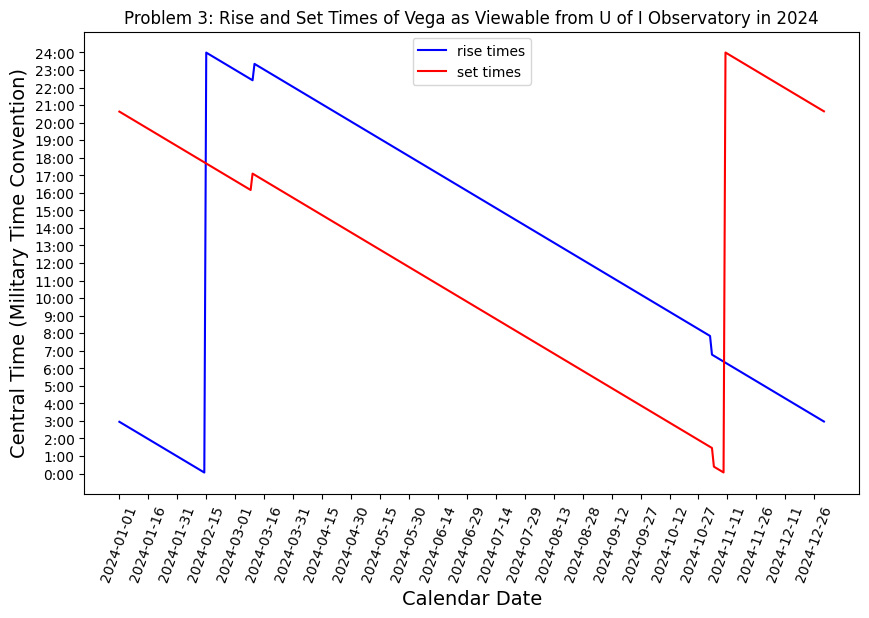

In [26]:
list_of_dates, CT_hrs_rise, CT_hrs_set = Calc_2024_Rise_Set(RA=RA_decimal_Vega, DEC=DEC_decimal_Vega, obs_lat=40.112, obs_long=-88.221)
plt.figure(figsize=(10,6))
plt.plot(list_of_dates, CT_hrs_rise, 'b-', label='rise times')
plt.plot(list_of_dates, CT_hrs_set, 'r-', label='set times')
plt.xticks(list_of_dates[::15], rotation=70);
plt.yticks(np.arange(0,25,1), [str(hourval)+':00' for hourval in np.arange(0,25,1)])
plt.legend(loc='upper center');
plt.title('Problem 3: Rise and Set Times of Vega as Viewable from U of I Observatory in 2024')
plt.xlabel('Calendar Date', fontsize=14);
plt.ylabel('Central Time (Military Time Convention)', fontsize=14);

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!